In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd  
import clamped_beam_wod as cbe
import sys

import keras
import keras.backend as K
from keras.models import Sequential
from keras.layers import Dropout
from keras.layers.core import Dense
from keras.optimizers import Adam
from flexmbd.utils import rot

from random import randint
import tensorflow as tf

### For better gpu usage ###
configuration = tf.compat.v1.ConfigProto()
configuration.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=configuration)

FEM: end displacement is 62.5 mm, rotation 5.371 deg
MBD: end displacement is 61.972 mm, rotation 5.335 deg
1001
FEM: end displacement is 112.5 mm, rotation 9.669 deg
MBD: end displacement is 109.54 mm, rotation 9.464 deg
1001
done simulating!


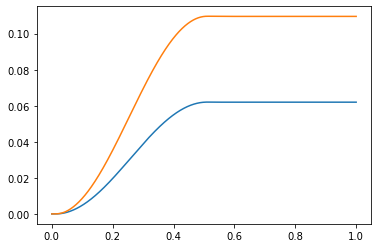

In [2]:
### Creating dataset from data points ###

n_elem = 40
l = 1
h = 0.02
E = 2e11
nu = 0.3
rho = 7801
Fy = 500.0 ## For first set
Fy2 = 900.0 ## For secound set 

## So only the force differs between training sets ##


vals = cbe.generate(n_elem, l, h, E, nu, rho, Fy) ## Generating the training data with separate module #

vals2 = cbe.generate(n_elem, l, h, E, nu, rho, Fy2) ## Generating the second set of training data with separate module #

print ("done simulating!")



In [3]:
### Creating arrays of forces applied on both sets ###

f_array = []
f_array2 = []

for i in range(1, 1002):
    f_array.append(Fy)
for i in range(1, 1002):
    f_array2.append(Fy2)    


In [ ]:
### Main problem comes from next cell. Problem is in the creating of dataframe that includes ###
### both training datasets and the constant values attached to them. One of the ways I tried:###
### Datasets are added together (Could be done better) and Force array is attached after each###
### dataset.Time step is atleast same with the sets. Under here datasets are put on own      ###
### dataframes and they are added to gether as two different inputs. This will cause errors  ###
### On Fitting since Sequential model won't allow two input tensors.                         ###

In [22]:
##Creating Pandas DF from data ##
dframe = pd.DataFrame()
dframe2 = pd.DataFrame()

## Adding the training data to dataframe ##
for i in range(len(vals[0])):
       dframe[i] = pd.DataFrame(vals[0][i])
        
dframe[50] = f_array ## adding force 1 to dframe

## Adding the second set of training data to dataframe ##
for i in range(len(vals2[0])):
       dframe2[i] = pd.DataFrame(vals2[0][i])        

dframe2[50] = f_array2 ## adding force 2 to dframe2


## Inputs and outputs and sifting ##
X = [dframe.drop(0), dframe2.drop(0)]
Y = dframe.drop(dframe.shape[0]-1).iloc[: , :-1]

#print (dframe)

#print (Y)
#print (X)

In [23]:
### CUSTOM LOSS FUNCTION ###

### using keras as backed for loss function ###

def custom_loss(y_true, y_pred):
    
    loss = K.square(y_pred - y_true) 
    loss = loss * 0.4
    
    
    return loss

In [24]:
### CREATING NN MODEL ###

model=Sequential([Dense(51,input_shape=(51,), activation="softplus"),
                  Dense(120,activation="softplus"),
                  Dense(140,activation="softplus"),  
                  Dense(120,activation="softplus"),  
                  Dense(50)])

model.compile(Adam(lr=0.001),loss=custom_loss)

In [ ]:
### With this approach I should probably change Sequential model to Functional API so I could input two tensors ###

In [25]:
###TRAINING OF MODEL ###

history = model.fit(X, Y, epochs=400, validation_split = 0.1)

##callbacks= [keras.callbacks.EarlyStopping(patience=5)],

Epoch 1/400


ValueError: in user code:

    C:\Users\Juho\anaconda3\envs\bach\lib\site-packages\tensorflow\python\keras\engine\training.py:806 train_function  *
        return step_function(self, iterator)
    C:\Users\Juho\anaconda3\envs\bach\lib\site-packages\tensorflow\python\keras\engine\training.py:796 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\Juho\anaconda3\envs\bach\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\Juho\anaconda3\envs\bach\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\Juho\anaconda3\envs\bach\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\Juho\anaconda3\envs\bach\lib\site-packages\tensorflow\python\keras\engine\training.py:789 run_step  **
        outputs = model.train_step(data)
    C:\Users\Juho\anaconda3\envs\bach\lib\site-packages\tensorflow\python\keras\engine\training.py:747 train_step
        y_pred = self(x, training=True)
    C:\Users\Juho\anaconda3\envs\bach\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:976 __call__
        self.name)
    C:\Users\Juho\anaconda3\envs\bach\lib\site-packages\tensorflow\python\keras\engine\input_spec.py:158 assert_input_compatibility
        ' input tensors. Inputs received: ' + str(inputs))

    ValueError: Layer sequential_4 expects 1 inputs, but it received 2 input tensors. Inputs received: [<tf.Tensor 'IteratorGetNext:0' shape=(None, 51) dtype=float64>, <tf.Tensor 'IteratorGetNext:1' shape=(None, 51) dtype=float64>]


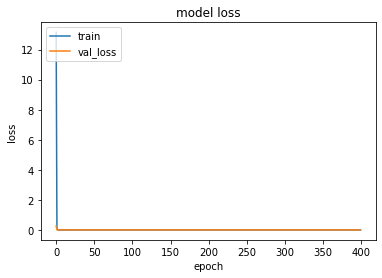

In [16]:
## Losses plotted ##

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val_loss'], loc='upper left')
plt.show()

1000
FEM: end displacement is 125 mm, rotation 10.74 deg
MBD: end displacement is 121 mm, rotation 10.47 deg
1001


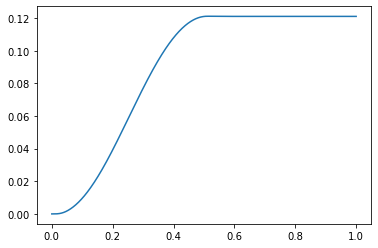

In [17]:
### Creating testing data ###
# Values are same as before except the Fy force #
n_elem = 40
l = 1
h = 0.02
E = 2e11
nu = 0.3
rho = 7801

Fy = 1000 #randint(450,750)
print(Fy)
testvals = cbe.generate(n_elem, l, h, E, nu, rho, Fy)## Generating testing data##
dframe2 = pd.DataFrame() ##Creating Pandas DF from data ##

for i in range(len(testvals[0])):
       dframe2[i] = pd.DataFrame(testvals[0][i])
        
dframe2[50] = np.full((len(dframe2[0]),1), Fy) ## Adding force to dframe


timeframe = pd.DataFrame(range(len(testvals[0][0]+1)), columns=["Time"]) ## For plotting resutlts

Y2 = dframe2
X2 = dframe2



In [26]:
#### Test ####
#np.set_printoptions(threshold=sys.maxsize)

results = model.evaluate(X, Y)
print(results)

displac_pred = [] ## List for predictions


xr = np.transpose(model.predict(np.array(X2)))
print (xr)
## Each array in xr represents predicted full state of model on each timestep              ##
## To plot in this example we only need row 50 of those arrays (row 50 means displacement) ##




ValueError: in user code:

    C:\Users\Juho\anaconda3\envs\bach\lib\site-packages\tensorflow\python\keras\engine\training.py:1224 test_function  *
        return step_function(self, iterator)
    C:\Users\Juho\anaconda3\envs\bach\lib\site-packages\tensorflow\python\keras\engine\training.py:1215 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\Juho\anaconda3\envs\bach\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\Juho\anaconda3\envs\bach\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\Juho\anaconda3\envs\bach\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\Juho\anaconda3\envs\bach\lib\site-packages\tensorflow\python\keras\engine\training.py:1208 run_step  **
        outputs = model.test_step(data)
    C:\Users\Juho\anaconda3\envs\bach\lib\site-packages\tensorflow\python\keras\engine\training.py:1174 test_step
        y_pred = self(x, training=False)
    C:\Users\Juho\anaconda3\envs\bach\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:976 __call__
        self.name)
    C:\Users\Juho\anaconda3\envs\bach\lib\site-packages\tensorflow\python\keras\engine\input_spec.py:158 assert_input_compatibility
        ' input tensors. Inputs received: ' + str(inputs))

    ValueError: Layer sequential_4 expects 1 inputs, but it received 2 input tensors. Inputs received: [<tf.Tensor 'IteratorGetNext:0' shape=(None, 51) dtype=float64>, <tf.Tensor 'IteratorGetNext:1' shape=(None, 51) dtype=float64>]


In [ ]:
print(xr[42])

In [ ]:
### Calculating the displacements ###

    # Real results #
print (len(testvals[0]))
ny = testvals[0].shape[0] // 2 + 1
r_end = np.empty((3, testvals[0].shape[1]))

for i in range(testvals[0].shape[1]):
    u_last = testvals[1].nodes[-1].origin @ testvals[0][14:ny, i]
    A_fb = rot(testvals[0][10:14, i])
    r_fb = testvals[0][7:10, i]
    r = r_fb + A_fb @ u_last
    r_end[:, i] = r

    
    # Simulated results #
#xr = xr[:-1]
print(len(xr))
ny2 = xr.shape[0] // 2 + 1
r_end2 = np.empty((3, xr.shape[1]))

for i in range(xr.shape[1]):
    u_last2 = testvals[1].nodes[-1].origin @ xr[14:ny2, i]
    A_fb2 = rot(xr[10:14, i])
    r_fb2 = xr[7:10, i]
    r2 = r_fb2 + A_fb2 @ u_last2
    r_end2[:, i] = r2


In [ ]:
plt.plot(timeframe, r_end[1])
plt.plot(timeframe, r_end2[1], linestyle='dashed', color='red')

plt.xlabel('t')
plt.legend([' REAL position',  'Predicted position'], shadow=True)
plt.title('BEAM System')
plt.show()